In [77]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px 


In [78]:
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder,MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,silhouette_score,confusion_matrix,accuracy_score 
from sklearn.linear_model import LogisticRegression,LinearRegression 
from sklearn.decomposition import PCA 
from sklearn.compose import ColumnTransformer 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans 
from sklearn.pipeline import Pipeline

In [79]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
data.head(1)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.924


In [80]:
mis_val = data.isna().sum() * 100/len(data)

mis_val.sort_values(ascending=False)

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [81]:
data.duplicated().sum()

data.drop_duplicates(keep='first', subset=None,inplace=True, ignore_index=False)

data.duplicated().sum()

0

<AxesSubplot:title={'center':'Correlation Matrix'}>

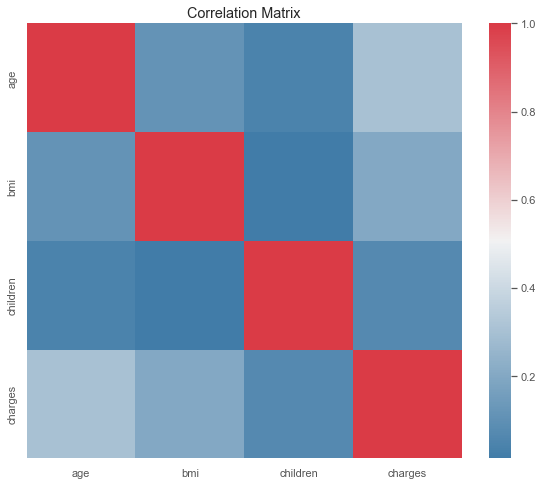

In [82]:
data_corr = data.corr()

f,ax = plt.subplots(figsize=(10,8))

ax.set_title('Correlation Matrix')

sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(240,10, as_cmap=True), ax=ax, square=True)